<div class="alert alert-warning" role="alert"; style="border:groove rgb(57,136,235) 5px; padding: 40px">


<h1 align="center" style="margin-bottom: -5px">Прогнозирование возврата заёма<a class="tocSkip"></h1>
<h4 align="center" style="margin-bottom: -5px">ШИФТ ГК ЦФТ<a class="tocSkip"></h4>
<h4 align="center" style="margin-bottom: 60px">Тестовое задание<a class="tocSkip"></h4>
<h4 align="right" style="margin-bottom: -15px">Исполнитель: Воронин Артём<a class="tocSkip"></h4> 

<h1 align="center">Описание проекта</h1>
<p style="margin-bottom: 30px"></p>
<h2>Задача:<span class="tocSkip"></span></h2>

Командой ШИФТ ЦФТ предоставлен набор данных о клиентах с информацией о их кредитной истории в банке. Необходимо для каждого клиента предсказать бинарный таргет, который равен 1, если займ не возвращен и 0, если заемщик вернул займ.

<h2>Оценка качества модели:<span class="tocSkip"></span></h2>
<p style="margin-bottom: 30px"></p>

Оценка модели будет делаться по метрике Gini:
$$
Gini = 2 * ROC AUC - 1
$$

Для построения модели, предоставляется обучающий набор клиентов X_train.csv с информацией о заемщиках. Целевая переменная находится в файле y_train.csv (1 = "невозврат")

Результат должен быть представлен в виде упакованного в zip CSV-файла с названием answer.csv и с колонками index и loan_status (где проставлена вероятность значения 1)


# 0 Подготовка к работе

<h2>Установка пакетов<span class="tocSkip"></span></h2>

При необходимости нужно раскоментировать пакеты для установки.

In [1]:
# !pip install catboost --quiet --disable-pip-version-check
# !pip install lightgbm --quiet --disable-pip-version-check
# !pip install xgboost --quiet --disable-pip-version-check
# !pip install torch --quiet --disable-pip-version-check
# !pip install transformers --quiet --disable-pip-version-check
# !pip install spacy --quiet --disable-pip-version-check
# !spacy download en --quiet --disable-pip-version-check
# !pip install -U nltk --quiet --disable-pip-version-check
# !pip install phik --quiet --disable-pip-version-check
# !pip install pyod --quiet --disable-pip-version-check

<h2>Импорт библиотек<span class="tocSkip"></span></h2>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import xgboost as xgb
import lightgbm as lgb
import warnings

# модели
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import *

from pyod.models.knn import KNN

from copy import deepcopy

from tqdm import tqdm

import phik
from phik.report import plot_correlation_matrix
from phik import report

<h2>Установки<span class="tocSkip"></span></h2>

In [3]:
COLOR = ['r', 'b', 'g', 'y', 'm', 'c', 'k']    # цвета для графиков

class txt:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

<h2>Константы<span class="tocSkip"></span></h2>

In [4]:
CV = 5         # кол-во разбиений для кросс-валидаций
RS = 321       # случайное значение

<h2>Метрики<span class="tocSkip"></span></h2>

In [5]:
# основная метрика Gini
def gini_score(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred) 
    return 2 * auc - 1
gini = make_scorer(gini_score, needs_proba=True)

f1 = make_scorer(f1_score)           # f1 мера
prec = make_scorer(precision_score)  # точность
rec = make_scorer(recall_score)      # полнота

# 1 Обзор данных

## 1.1 Загрузка датасетов

Загружаем все датасеты функцией:

In [6]:
def data_load(name):
    '''Загружает датасет из файла'''
    
    home_dir = os.path.abspath("")
    
    try:
        data = pd.read_csv(f'{home_dir}/{name}', index_col=[0], parse_dates=True)
        print(f'{name} успешно загружен!')
        return data    
    except:
        try:
            data = pd.read_csv(f'C:/Users/Admin/PythonPrograms/ШИФТ/{name}',
                              index_col=[0], parse_dates=True)
            print(f'{name} успешно загружен! (полный путь)')
            return data
        except:  
            print(f'Ошибка месторасположения csv-файла "{name}"')

In [7]:
# тренировочный датасет (фичи)
x_train = data_load('X_train.csv')

# тренировочный датасет (таргет)
y_train = data_load('y_train.csv')

# тестовый датасет (фичи)
x_test = data_load('X_test.csv')

X_train.csv успешно загружен!
y_train.csv успешно загружен!
X_test.csv успешно загружен!


Проверка соответствия индексов фичей и таргета:

In [8]:
print(
    'Индексы датасетов {}совпадают' 
    .format(('не ', '')[all(x_train.index == y_train.index)])
)

Индексы датасетов совпадают


**Вывод:** Данные успешно загружены, ошибок в файлах и датасетах нет, индексы объектов совпадают.

## 1.2 Предварительный обзор

<h3>Блок функций<span class="tocSkip"></span></h3>

In [9]:
def pass_value_barh(df, figsize=(10, 5), fontsize=10):
    '''Строит гистограмму пропусков и их долю в %'''
    
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=figsize, legend=False, fontsize=fontsize)
            .set_title('Гистограмма пропусков\n', fontsize=16, color='SteelBlue')
        );   
        print('\nДоля пропусков: {:.4%}'.format(df.isna().mean().mean()))
    except:
        plt.close();
        print('Пропусков нет 😎')

In [10]:
def data_eda(df, figsize=(10, 5), fontsize=10):
    '''Предварительный обзор данных:
        - тип датасета
        - основная информация
        - описательные хар-ки
        - дубликаты
        - пропуски'''
    
    df.info()
    with pd.option_context('display.max_columns', None,):
        display(df.sample(6), df.describe().round(2))
    print(f'\nКол-во явных дубликатов: {df.duplicated().sum()}', end='\n\n')
    pass_value_barh(df, figsize, fontsize)  

### 1.3 X_train

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1199861 entries, 0 to 1199860
Data columns (total 44 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   acc_now_delinq              1199861 non-null  float64
 1   addr_state                  1199861 non-null  object 
 2   annual_inc                  1199861 non-null  float64
 3   chargeoff_within_12_mths    1199824 non-null  float64
 4   collections_12_mths_ex_med  1199824 non-null  float64
 5   delinq_2yrs                 1199861 non-null  float64
 6   dti                         1199861 non-null  float64
 7   earliest_cr_line            1199861 non-null  object 
 8   emp_length                  1128114 non-null  object 
 9   fico_range_high             1199861 non-null  float64
 10  fico_range_low              1199861 non-null  float64
 11  funded_amnt                 1199861 non-null  float64
 12  home_ownership              1199861 non-null  object 
 1

,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,inq_last_12m,installment,int_rate,issue_d,loan_amnt,mort_acc,mths_since_last_delinq,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,purpose,revol_util,tax_liens,term,title,total_acc,verification_status,zip_code
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
171011,0.0,MI,57000.0,0.0,0.0,0.0,9.83,Feb-2000,NaN,679.0,675.0,10000.0,MORTGAGE,NaN,330.57,11.67%,Jul-2014,10000.0,1.0,NaN,NaN,6.0,0.0,3.0,8.0,8.0,0.0,0.0,0.0,1.0,8.0,NaN,NaN,33.3,0.0,0.0,credit_card,52.1%,0.0,36 months,Credit card refinancing,11.0,Source Verified,481xx
1133401,0.0,FL,114000.0,0.0,0.0,0.0,27.79,Oct-1983,4 years,754.0,750.0,6000.0,OWN,3.0,188.69,8.24%,Mar-2017,6000.0,3.0,35.0,NaN,8.0,0.0,4.0,25.0,21.0,0.0,0.0,0.0,3.0,21.0,2.0,2.0,0.0,0.0,0.0,debt_consolidation,25.3%,0.0,36 months,Debt consolidation,39.0,Not Verified,322xx
565742,0.0,CO,42511.0,0.0,0.0,0.0,19.59,Feb-2000,< 1 year,734.0,730.0,19100.0,RENT,NaN,613.35,9.67%,Feb-2014,19100.0,0.0,NaN,NaN,NaN,0.0,2.0,8.0,6.0,0.0,0.0,0.0,0.0,6.0,NaN,NaN,66.7,0.0,0.0,credit_card,73.9%,0.0,36 months,Credit card refinancing,14.0,Verified,809xx
878662,0.0,GA,75000.0,0.0,0.0,0.0,6.40,Aug-2003,8 years,754.0,750.0,12000.0,MORTGAGE,0.0,242.81,7.91%,Dec-2015,12000.0,2.0,NaN,NaN,NaN,0.0,1.0,5.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,50.0,0.0,0.0,debt_consolidation,59.8%,0.0,60 months,Debt consolidation,10.0,Not Verified,312xx
707975,0.0,NY,72716.0,0.0,0.0,0.0,27.44,Jul-1969,NaN,674.0,670.0,27525.0,OWN,NaN,1022.79,19.99%,Apr-2014,27525.0,2.0,36.0,36.0,6.0,6.0,4.0,36.0,16.0,0.0,0.0,0.0,5.0,16.0,NaN,NaN,40.0,0.0,0.0,debt_consolidation,66.5%,0.0,36 months,Debt consolidation,47.0,Verified,123xx
454927,0.0,CA,91080.0,0.0,0.0,1.0,15.90,Mar-1999,10+ years,689.0,685.0,21000.0,MORTGAGE,NaN,458.06,11.14%,Feb-2013,21000.0,5.0,20.0,NaN,NaN,1.0,5.0,21.0,10.0,0.0,0.0,1.0,1.0,10.0,NaN,NaN,50.0,0.0,0.0,home_improvement,49.2%,0.0,60 months,Getting back on track,31.0,Source Verified,959xx


,acc_now_delinq,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,fico_range_high,fico_range_low,funded_amnt,inq_last_12m,installment,loan_amnt,mort_acc,mths_since_last_delinq,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,tax_liens,total_acc
count,1199861.00,1.199861e+06,1199824.00,1199824.00,1199861.00,1199861.00,1199861.00,1199861.00,1199861.00,632646.00,1199861.00,1199861.00,1168320.00,592418.00,282665.00,1050080.00,1154852.00,1154852.00,1154851.00,1162566.00,1109253.00,1154852.00,1154852.00,1154852.00,1199861.00,632647.00,632647.00,1155527.00,1199861.00,1199394.00,1199833.00,1199861.00
mean,0.00,7.811051e+04,0.01,0.02,0.31,18.04,701.20,697.20,14404.66,2.18,435.32,14410.91,1.60,34.42,39.44,6.83,0.51,3.66,14.33,11.65,0.00,0.00,0.09,2.16,11.62,1.68,2.90,43.18,0.21,0.13,0.05,24.64
std,0.07,1.363514e+05,0.11,0.15,0.88,8.40,32.34,32.34,8855.22,2.46,263.58,8858.04,1.95,21.88,22.65,5.88,1.35,2.29,8.12,5.58,0.03,0.06,0.50,1.85,5.57,1.64,2.67,36.14,0.59,0.37,0.39,12.05
min,0.00,2.300000e+03,0.00,0.00,0.00,-1.00,664.00,660.00,500.00,0.00,4.93,500.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
25%,0.00,4.700000e+04,0.00,0.00,0.00,11.74,674.00,670.00,7675.00,0.00,244.66,7700.00,0.00,16.00,21.00,2.00,0.00,2.00,8.00,8.00,0.00,0.00,0.00,1.00,8.00,1.00,1.00,0.00,0.00,0.00,0.00,16.00
50%,0.00,6.500000e+04,0.00,0.00,0.00,17.55,694.00,690.00,12000.00,2.00,370.37,12000.00,1.00,31.00,37.00,5.00,0.00,3.00,13.00,11.00,0.00,0.00,0.00,2.00,11.00,1.00,2.00,40.00,0.00,0.00,0.00,23.00
75%,0.00,9.300000e+04,0.00,0.00,0.00,23.97,719.00,715.00,20000.00,3.00,576.76,20000.00,3.00,50.00,58.00,10.00,0.00,5.00,18.00,14.00,0.00,0.00,0.00,3.00,14.00,2.00,4.00,75.00,0.00,0.00,0.00,31.00
max,6.00,1.100000e+08,10.00,20.00,42.00,49.96,850.00,845.00,40000.00,49.00,1719.83,40000.00,61.00,226.00,198.00,25.00,51.00,50.00,128.00,90.00,6.00,4.00,42.00,32.00,90.00,39.00,54.00,100.00,86.00,12.00,85.00,173.00



Кол-во явных дубликатов: 0


Доля пропусков: 7.4570%


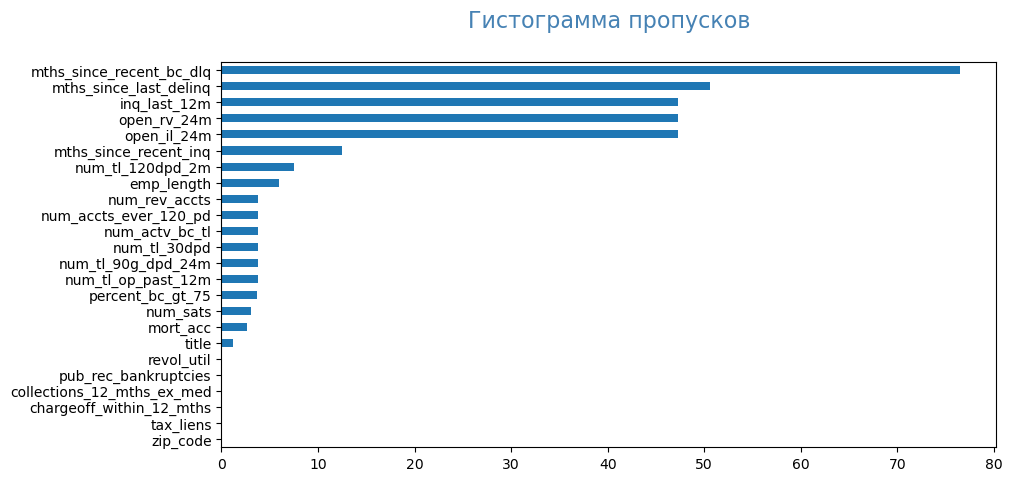

In [11]:
data_eda(x_train)

### 1.3 Y_train

In [12]:
data_eda(y_train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1199861 entries, 0 to 1199860
Data columns (total 1 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   loan_status  1199861 non-null  int64
dtypes: int64(1)
memory usage: 18.3 MB


,loan_status
index,
961528,0
522809,0
791012,0
1015109,0
213593,1
868312,0


,loan_status
count,1199861.00
mean,0.19
std,0.39
min,0.00
25%,0.00
50%,0.00
75%,0.00
max,1.00



Кол-во явных дубликатов: 1199859

Пропусков нет 😎


Посмотрим на соотношение классов:

Соотношение классов 1:4.18


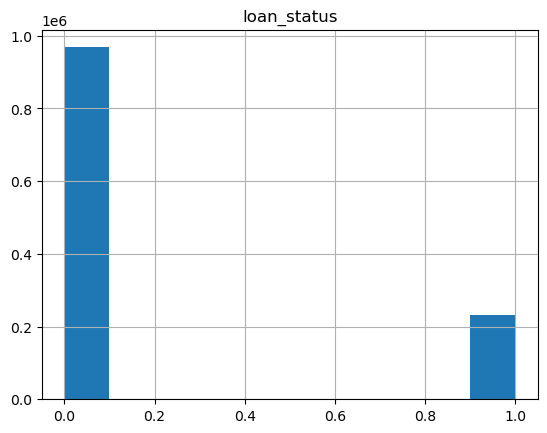

In [13]:
y_train.hist();
tmp = y_train.value_counts()
print('Соотношение классов 1:', (tmp[0] / tmp[1]).round(2), sep='')

### 1.3 X_test

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1199861 entries, 0 to 1199860
Data columns (total 44 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   acc_now_delinq              1199861 non-null  float64
 1   addr_state                  1199861 non-null  object 
 2   annual_inc                  1199861 non-null  float64
 3   chargeoff_within_12_mths    1199824 non-null  float64
 4   collections_12_mths_ex_med  1199824 non-null  float64
 5   delinq_2yrs                 1199861 non-null  float64
 6   dti                         1199861 non-null  float64
 7   earliest_cr_line            1199861 non-null  object 
 8   emp_length                  1128114 non-null  object 
 9   fico_range_high             1199861 non-null  float64
 10  fico_range_low              1199861 non-null  float64
 11  funded_amnt                 1199861 non-null  float64
 12  home_ownership              1199861 non-null  object 
 1

,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,inq_last_12m,installment,int_rate,issue_d,loan_amnt,mort_acc,mths_since_last_delinq,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,purpose,revol_util,tax_liens,term,title,total_acc,verification_status,zip_code
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
472090,0.0,NY,28600.0,0.0,0.0,0.0,31.85,Nov-2002,8 years,674.0,670.0,7375.0,OWN,NaN,265.78,17.77%,Oct-2012,7375.0,0.0,NaN,NaN,NaN,0.0,4.0,13.0,11.0,0.0,0.0,0.0,1.0,11.0,NaN,NaN,100.0,0.0,0.0,debt_consolidation,94.1%,0.0,36 months,Debt Consolidation,21.0,Verified,130xx
827843,0.0,IL,60000.0,0.0,0.0,1.0,16.88,Mar-2004,8 years,684.0,680.0,7000.0,OWN,0.0,222.57,8.99%,Oct-2016,7000.0,0.0,12.0,NaN,NaN,0.0,1.0,4.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,100.0,1.0,1.0,other,84.8%,0.0,36 months,Other,11.0,Verified,600xx
330226,0.0,IN,90000.0,0.0,0.0,0.0,7.71,Dec-2005,1 year,739.0,735.0,20000.0,MORTGAGE,1.0,622.96,7.59%,Jun-2016,20000.0,2.0,NaN,NaN,5.0,0.0,2.0,15.0,14.0,0.0,0.0,0.0,2.0,14.0,1.0,8.0,28.6,0.0,0.0,credit_card,18.8%,0.0,36 months,Credit card refinancing,25.0,Source Verified,465xx
1116339,0.0,CA,50000.0,0.0,0.0,0.0,29.98,Nov-1984,1 year,689.0,685.0,8000.0,RENT,1.0,264.96,11.80%,Jan-2019,8000.0,0.0,NaN,NaN,12.0,0.0,10.0,20.0,18.0,0.0,0.0,0.0,0.0,18.0,1.0,3.0,63.6,0.0,0.0,debt_consolidation,62.5%,0.0,36 months,Debt consolidation,23.0,Not Verified,907xx
397714,0.0,AL,82000.0,0.0,0.0,0.0,17.84,May-2006,10+ years,704.0,700.0,30000.0,MORTGAGE,2.0,794.82,20.00%,Nov-2017,30000.0,2.0,24.0,24.0,8.0,1.0,9.0,15.0,18.0,0.0,0.0,0.0,5.0,18.0,2.0,8.0,0.0,0.0,0.0,home_improvement,20%,0.0,60 months,Home improvement,25.0,Verified,351xx
973180,0.0,CA,30000.0,0.0,0.0,0.0,1.00,Nov-2002,NaN,779.0,775.0,20000.0,OWN,2.0,523.45,19.42%,Mar-2018,20000.0,0.0,NaN,NaN,0.0,0.0,1.0,6.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,debt_consolidation,0.7%,0.0,60 months,Debt consolidation,7.0,Source Verified,907xx


,acc_now_delinq,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,fico_range_high,fico_range_low,funded_amnt,inq_last_12m,installment,loan_amnt,mort_acc,mths_since_last_delinq,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,tax_liens,total_acc
count,1199861.00,1.199861e+06,1199824.00,1199824.00,1199861.00,1199861.00,1199861.00,1199861.00,1199861.00,632646.00,1199861.00,1199861.00,1168320.00,592418.00,282665.00,1050080.00,1154852.00,1154852.00,1154851.00,1162566.00,1109253.00,1154852.00,1154852.00,1154852.00,1199861.00,632647.00,632647.00,1155527.00,1199861.00,1199394.00,1199833.00,1199861.00
mean,0.00,7.811051e+04,0.01,0.02,0.31,18.04,701.20,697.20,14404.66,2.18,435.32,14410.91,1.60,34.42,39.44,6.83,0.51,3.66,14.33,11.65,0.00,0.00,0.09,2.16,11.62,1.68,2.90,43.18,0.21,0.13,0.05,24.64
std,0.07,1.363514e+05,0.11,0.15,0.88,8.40,32.34,32.34,8855.22,2.46,263.58,8858.04,1.95,21.88,22.65,5.88,1.35,2.29,8.12,5.58,0.03,0.06,0.50,1.85,5.57,1.64,2.67,36.14,0.59,0.37,0.39,12.05
min,0.00,2.300000e+03,0.00,0.00,0.00,-1.00,664.00,660.00,500.00,0.00,4.93,500.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
25%,0.00,4.700000e+04,0.00,0.00,0.00,11.74,674.00,670.00,7675.00,0.00,244.66,7700.00,0.00,16.00,21.00,2.00,0.00,2.00,8.00,8.00,0.00,0.00,0.00,1.00,8.00,1.00,1.00,0.00,0.00,0.00,0.00,16.00
50%,0.00,6.500000e+04,0.00,0.00,0.00,17.55,694.00,690.00,12000.00,2.00,370.37,12000.00,1.00,31.00,37.00,5.00,0.00,3.00,13.00,11.00,0.00,0.00,0.00,2.00,11.00,1.00,2.00,40.00,0.00,0.00,0.00,23.00
75%,0.00,9.300000e+04,0.00,0.00,0.00,23.97,719.00,715.00,20000.00,3.00,576.76,20000.00,3.00,50.00,58.00,10.00,0.00,5.00,18.00,14.00,0.00,0.00,0.00,3.00,14.00,2.00,4.00,75.00,0.00,0.00,0.00,31.00
max,6.00,1.100000e+08,10.00,20.00,42.00,49.96,850.00,845.00,40000.00,49.00,1719.83,40000.00,61.00,226.00,198.00,25.00,51.00,50.00,128.00,90.00,6.00,4.00,42.00,32.00,90.00,39.00,54.00,100.00,86.00,12.00,85.00,173.00



Кол-во явных дубликатов: 0


Доля пропусков: 7.4570%


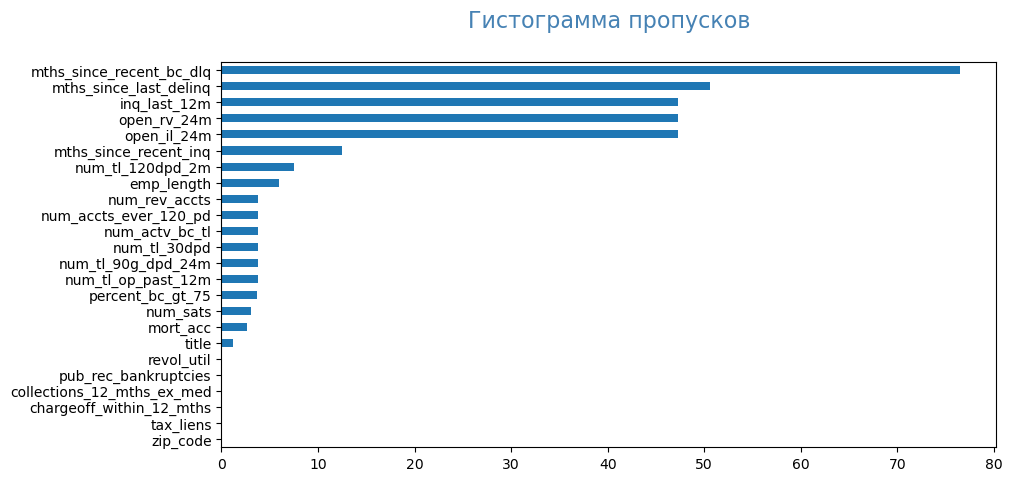

In [14]:
data_eda(x_train)

# 2 Обработка пропусков

Рассмотрим признаки с пропусками и попытаемся их обработать/заменить. Для отслеживания изменения метрики напишем функцию **check**, в которую будем подавать данные после какой-либо обработки и получать посчитанную метрику Gini. Основной датасет с фичами `x_train` не трогаем, а работает с его полной копией. Если обработка принесла положительный результат, то будем вносить эти зименения уже в основной датасет.

> ***Примечание.*** В функии используются заранее обученные модели (одна линейная и одна бустинговая) с перебранными в GreadSearch параметрами.

In [15]:
# параметры модели логистической регрессии
params_lr = { 
    'penalty': 'l2',                       
    'C': 0.75,                 
    'class_weight': None,          
    'random_state': RS,                      
    'solver': 'lbfgs'        
}

# параметры модели LGBM
params_lgbm = { 
    'max_depth': 9,                    
    'n_estimators': 96,                        
    'learning_rate': 0.27,   
    'boosting_type': 'gbdt',        
    'random_state': [RS]
}

In [16]:
def check(features, out=True, ret=False, cv=CV):
    '''Функция для тестирования метрики Gini моделей линейной регрессии
        и LGBM на предобработанных данных. Пропуски заменены средним,
        объектовые признаки закодированы Ordinal энкодером и 
        масштабированы Standart скалером'''
    
    # создание копии датасета фичей и таргета
    # будем работать с копией, чтобы не изменялся основной датасет
    x = deepcopy(features)
    y = deepcopy(y_train)    
    
    '''Обработка пропусков'''
    # численные (среднее)
    digit = x.select_dtypes(exclude=['object'])
    for i in digit.columns[digit.isna().any()]:
        fill_value = x[i].mean()
        x[i] = x[i].fillna(fill_value)
    # объектовые (мода)
    obj = x.select_dtypes(include=['object']).columns
    x[obj] = x[obj].apply(lambda z:z.fillna(z.value_counts().index[0]))


    '''Кодирование объектовых признаков'''
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    encoder.fit(x[obj])
    x[obj] = encoder.transform(x[obj])
    
    # синхронизируем целевой признак с фичами после предобработки
    y = y.loc[x.index]

    '''Масштабирование'''
    scaler = StandardScaler()
    scaler.fit(x)
    x_sc = deepcopy(x)
    x_sc = scaler.transform(x_sc)    


    '''Обучение моделей, подсчет метрик'''
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        # LGBM
        lgbm_sc = cross_val_score(LGBMClassifier(**params_lgbm, verbose=-1), x_sc, 
                                     y, scoring=gini, cv=cv).mean()
   
        # логистическая регрессия
        lr_sc = cross_val_score(LogisticRegression(**params_lr), x_sc, 
                                   y, scoring=gini, cv=cv).mean()
        
    # вывод метрик на экран
    if out==True:
        print('LGBMClassifier:', lgbm_sc, '\n\nLogisticRegression:', lr_sc)
    
    # возврат значений метрик
    if ret == True:
        return lgbm_sc, lr_sc

In [17]:
check(x_train)  # сток

LGBMClassifier: 0.44358466942764385 

LogisticRegression: 0.4096855842363338


## 2.1 Столбцы

### 2.1.1 Численные признаки

In [93]:
'''инициализация списка признаков
пропуски в признаках из списка будут рекурсивно 
удаляться для нахождения лучшей метрики'''

features_del = []

Процент пропусков по признакам:

In [19]:
( 
    (x_train.select_dtypes(exclude=['object']).isna().mean()*100)
    .to_frame()
    .rename(columns = {0:'val'})
    .query('val > 0')
    .sort_values(by='val')
    .round(3)
)

,val
tax_liens,0.002
chargeoff_within_12_mths,0.003
collections_12_mths_ex_med,0.003
pub_rec_bankruptcies,0.039
mort_acc,2.629
num_sats,3.108
percent_bc_gt_75,3.695
num_tl_op_past_12m,3.751
num_tl_90g_dpd_24m,3.751
num_accts_ever_120_pd,3.751


Рассмотрим столбцы с наибольшим кол-вом пропусков:

**mths_since_recent_bc_dlq**

Месяцы с момента последней просрочки по банковской карте

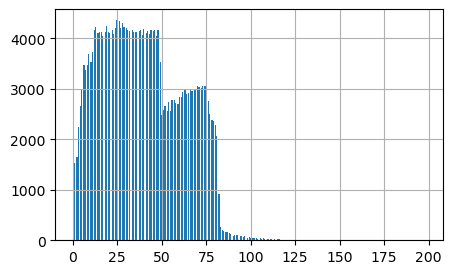

In [20]:
x_train['mths_since_recent_bc_dlq'].hist(figsize=(5, 3), bins=300);

Сделаем предположение, что пропуски это отсутствие просрочек, т.е. значение 0 и заменим пропуски:

In [21]:
x_tmp = deepcopy(x_train)
x_tmp['mths_since_recent_bc_dlq'] = x_tmp['mths_since_recent_bc_dlq'].fillna(0)
check(x_tmp)

LGBMClassifier: 0.44405681878971154 

LogisticRegression: 0.409686325665272


Метрика на кросс-валидации выросла.

**mths_since_last_delinq**

Количество месяцев, прошедших с момента последней просрочки заемщиком.

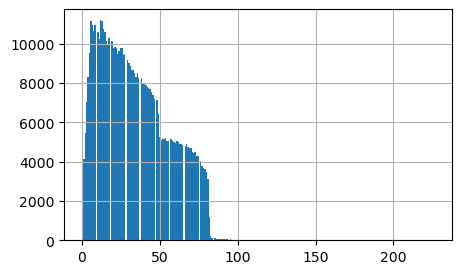

In [23]:
x_train['mths_since_last_delinq'].hist(figsize=(5, 3), bins=250);

Сделаем аналогичное предположение и заменим пропуски на 0:

In [24]:
x_tmp = deepcopy(x_train)
x_tmp['mths_since_last_delinq'] = x_tmp['mths_since_last_delinq'].fillna(0)
check(x_tmp)

LGBMClassifier: 0.4436813132601648 

LogisticRegression: 0.40968481548839114


Неоднозначное изменение метрики. Добавим признак в список:

In [94]:
features_del.append('mths_since_last_delinq')

**inq_last_12m**

Количество запросов на получение кредита за последние 12 месяцев

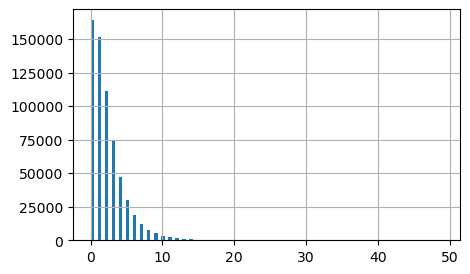

In [26]:
x_train['inq_last_12m'].hist(figsize=(5, 3), bins=100);

Сделаем аналогичное предположение и заменим пропуски на 0:

In [27]:
x_tmp = deepcopy(x_train)
x_tmp['inq_last_12m'] = x_tmp['inq_last_12m'].fillna(0)
check(x_tmp)

LGBMClassifier: 0.44438900822070637 

LogisticRegression: 0.4112461077037704


Метрика на кросс-валидации выросла.

**open_il_24m**

Количество счетов в рассрочку, открытых за последние 24 месяца

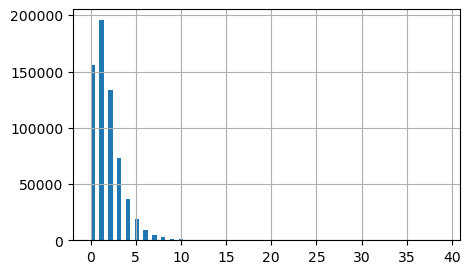

In [29]:
x_train['open_il_24m'].hist(figsize=(5, 3), bins=80);

Сделаем аналогичное предположение и заменим пропуски на 0:

In [30]:
x_tmp = deepcopy(x_train)
x_tmp['open_il_24m'] = x_tmp['open_il_24m'].fillna(0)
check(x_tmp)

LGBMClassifier: 0.4436780499884126 

LogisticRegression: 0.41049084282436465


Метрика на кросс-валидации выросла.

**open_rv_24m**

Количество возобновляемых сделок, открытых за последние 24 месяца

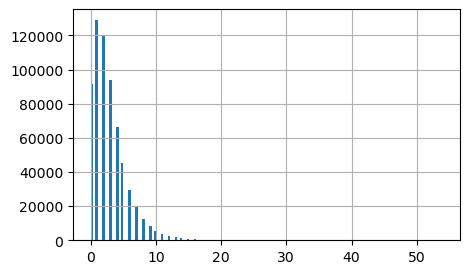

In [32]:
x_train['open_rv_24m'].hist(figsize=(5, 3), bins=150);

Сделаем аналогичное предположение и заменим пропуски на 0:

In [33]:
x_tmp = deepcopy(x_train)
x_tmp['open_rv_24m'] = x_tmp['open_rv_24m'].fillna(0)
check(x_tmp)

LGBMClassifier: 0.44378873394175355 

LogisticRegression: 0.41250522506348003


Метрика на кросс-валидации выросла. 

**mths_since_recent_inq**

Месяцев с момента последнего запроса.

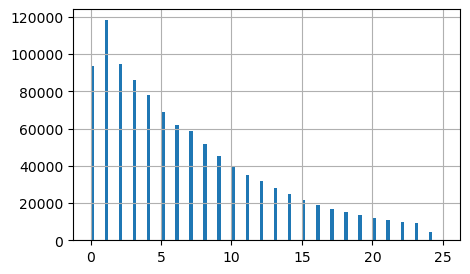

In [35]:
x_train['mths_since_recent_inq'].hist(figsize=(5, 3), bins=100);

Сделаем аналогичное предположение и заменим пропуски на 0:

In [36]:
x_tmp = deepcopy(x_train)
x_tmp['mths_since_recent_inq'] = x_tmp['mths_since_recent_inq'].fillna(0)
check(x_tmp)

LGBMClassifier: 0.44370160923552665 

LogisticRegression: 0.40912197021815955


Неоднозначное изменение метрики. Добавим признак в список на удаление:

In [96]:
features_del.append('mths_since_recent_inq')

**num_tl_120dpd_2m**

Количество счетов, просроченных на данный момент на 120 дней (обновлено за последние 2 месяца)

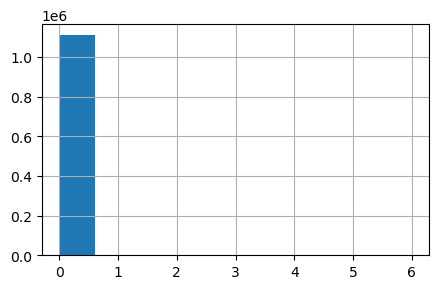

In [38]:
x_train['num_tl_120dpd_2m'].hist(figsize=(5, 3), bins=10);

In [39]:
x_train['num_tl_120dpd_2m'].value_counts()

0.0    1108495
1.0        724
2.0         29
3.0          3
4.0          1
6.0          1
Name: num_tl_120dpd_2m, dtype: int64

In [40]:
x_train['acc_now_delinq'].value_counts()

0.0    1194659
1.0       4910
2.0        248
3.0         36
4.0          5
5.0          2
6.0          1
Name: acc_now_delinq, dtype: int64

In [41]:
x_train['num_tl_120dpd_2m'].corr(x_train['acc_now_delinq'])

0.3922902184979371

Т.к. между признаками есть зависимость, попробуем восстановить пропуски:

In [42]:
x_tmp = deepcopy(x_train)
x_tmp['num_tl_120dpd_2m'] = x_tmp['num_tl_120dpd_2m'].fillna(x_tmp['acc_now_delinq'])
x_tmp['num_tl_120dpd_2m'].isna().sum()

0

Проверим изменение метрики:

In [43]:
check(x_tmp)

LGBMClassifier: 0.4436815895923637 

LogisticRegression: 0.4096923538834856


Метрика на кросс-валидации выросла. Но **на тесте упала**.

Попробуем также заменить на 0. 

In [44]:
x_tmp = deepcopy(x_train)
x_tmp['num_tl_120dpd_2m'] = x_tmp['num_tl_120dpd_2m'].fillna(0)
check(x_tmp)

LGBMClassifier: 0.4436815895923637 

LogisticRegression: 0.40968561803344405


Метрика на кросс-валидации выросла. 

**emp_length**

Стаж работы в годах. Возможные значения находятся в диапазоне от 0 до 10, где 0 означает менее одного года, а 10 означает десять или более лет.

In [46]:
x_train['emp_length'].value_counts()

10+ years    396911
2 years      109336
3 years       96813
< 1 year      94486
1 year        79958
5 years       75440
4 years       72998
6 years       55398
8 years       51577
7 years       51168
9 years       44029
Name: emp_length, dtype: int64

Произведем замену на численные значения:

In [47]:
replace_dict = {
    '10+ years': 10,
    '2 years': 2,
    '3 years': 3,
    '< 1 year': 0,
    '1 year': 1,
    '5 years': 5,
    '4 years': 4,
    '6 years': 6,
    '8 years': 8,
    '7 years': 7,
    '9 years': 9
}

x_tmp = deepcopy(x_train)
x_tmp['emp_length'] = x_tmp['emp_length'].replace(replace_dict)
x_tmp['emp_length'].value_counts()

10.0    396911
2.0     109336
3.0      96813
0.0      94486
1.0      79958
5.0      75440
4.0      72998
6.0      55398
8.0      51577
7.0      51168
9.0      44029
Name: emp_length, dtype: int64

In [48]:
check(x_tmp)

LGBMClassifier: 0.44647987633900926 

LogisticRegression: 0.40991219278533697


Метрика выросла, занесем изменение в основной тренировочный датасет:

In [49]:
x_train['emp_length'] = x_train['emp_length'].replace(replace_dict)

***Проверка на тесте***

Выделим в список все признаки, увеличивающие метрику на кросс-валидации:

In [97]:
tmp_lst = ['mths_since_recent_bc_dlq', 'inq_last_12m', 'open_il_24m', 'open_rv_24m', 'num_tl_120dpd_2m']

In [98]:
x_tmp = deepcopy(x_train)

for i in tmp_lst:
    x_tmp[i] = x_tmp[i].fillna(0)

- После замены пропусков на 0 в признаках из списка **метрика на тесте упала**

Добавим выделенные признаки в список на рекурсивное удаление:

In [101]:
features_del.extend(tmp_lst)

**Остальные столбцы**

Путем рекурсивного перебора (ниже) был определен список столбцов для удаления пропусков:

In [50]:
# признаки, удаление которых УЛУЧШАЕТ метрику
na_lst = ['num_rev_accts', 'emp_length', 'percent_bc_gt_75']

In [51]:
# в раннее созданный список добавляем те признаки, удаление которых явно снижает метрику 
features_del.append('mths_since_recent_inq')

In [52]:
# итоговый список признаков для перебора
na_col = list(set(x_train.columns[x_train.isna().any()] ) - set(features_del) - set(na_lst))

In [53]:
'''Здесь осуществлялся рекурсивный перебор по СТОЛБЦАМ'''

x_tmp = deepcopy(x_train)
x_tmp = x_tmp.dropna(subset=na_lst)
sc_lgbm, sc_lr = check(x_tmp, ret=True)

na_tbl = pd.DataFrame({
    '-Признак': 'FULL', 
    'LGBM Gini': sc_lgbm,
    'LR Gini': sc_lr 
    }, index=[0])


for i in tqdm(na_col):
    x_tmp = deepcopy(x_train)
    x_tmp = x_tmp.dropna(subset=na_lst)
    x_tmp = x_tmp.dropna(subset=[i])
    lgbm_score_na, lr_score_na = check(x_tmp, out=False, ret=True)      
    na_tbl.loc[-1] = [i, lgbm_score_na, lr_score_na]   
    na_tbl = na_tbl.reset_index(drop=True)

LGBMClassifier: 0.44861911608447463 

LogisticRegression: 0.4177700153090895


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [13:14<00:00, 56.77s/it]


In [54]:
na_tbl.sort_values(by=['LGBM Gini', 'LR Gini'], ascending=False)

,-Признак,LGBM Gini,LR Gini
0,FULL,0.448619,0.417770
2,num_actv_bc_tl,0.448619,0.417770
4,collections_12_mths_ex_med,0.448619,0.417770
5,num_sats,0.448619,0.417770
6,chargeoff_within_12_mths,0.448619,0.417770
7,tax_liens,0.448619,0.417770
8,num_tl_op_past_12m,0.448619,0.417770
9,num_accts_ever_120_pd,0.448619,0.417770
11,num_tl_90g_dpd_24m,0.448619,0.417770
12,pub_rec_bankruptcies,0.448619,0.417770


***Проверкана тесте***

- После удаления `na_lst` и отдельно `num_rev_accts` из датасета **метрика на тесте упала**.

Попробуем удалить пропуски по всем оставшимся признакам. Это сильно уменьшит датасет и увеличит скорость работы.

In [55]:
x_tmp = deepcopy(x_train)
x_tmp = x_tmp.dropna(subset=['pub_rec_bankruptcies', 'chargeoff_within_12_mths', 'num_tl_30dpd', 
                             'tax_liens', 'collections_12_mths_ex_med', 'num_sats','num_tl_90g_dpd_24m', 
                             'pub_rec_bankruptcies', 'num_actv_bc_tl', 'num_tl_op_past_12m', 
                             'num_accts_ever_120_pd', 'mort_acc'])
x_tmp.shape

(1154852, 44)

In [56]:
check(x_tmp)

LGBMClassifier: 0.44760326743399165 

LogisticRegression: 0.4113699671556116


После удаления оставшихся пропусков из датасета метрика на кросс-валидации выросла, но **на тесте упала**.

**Вывод:** Вероятнее всего тест не любит, когда уменьшается датасет.

### 2.1.2 Строковые признаки

In [57]:
( 
    (x_train.select_dtypes(include=['object']).isna().mean()*100)
    .to_frame()
    .rename(columns = {0:'val'})
    .query('val > 0')
    .sort_values(by='val')
    .round(4)
)

,val
zip_code,0.0001
revol_util,0.0701
title,1.1501


Заменим пропуски в каждом столбце на моду последовательно и сравним метрику:

In [58]:
na_tbl = pd.DataFrame({
    'Признак': 'FULL', 
    'LGBM Gini': .44675981307647505,
    'LR Gini': 0.40988903806480553 
    }, index=[0])

for i in tqdm(['zip_code', 'revol_util', 'title']):
    x_tmp = deepcopy(x_train)
    x_tmp[[i]] = x_tmp[[i]].apply(lambda x:x.fillna(x.value_counts().index[0]))
    lgbm_score_na, lr_score_na = check(x_tmp, out=False, ret=True)      
    na_tbl.loc[-1] = [i, lgbm_score_na, lr_score_na]   
    na_tbl = na_tbl.reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:03<00:00, 61.23s/it]


In [59]:
na_tbl.sort_values(by=['LGBM Gini', 'LR Gini'], ascending=False)

,Признак,LGBM Gini,LR Gini
0,FULL,0.44676,0.409889
1,zip_code,0.44648,0.409912
2,revol_util,0.44648,0.409912
3,title,0.44648,0.409912


Метрика неоднозначно изменилась. Попробуем заменить пропуски во всех 3 столбцах одновременно:

In [60]:
lst_tmp = ['zip_code', 'revol_util', 'title']
x_tmp = deepcopy(x_train)
x_tmp[lst_tmp] = x_tmp[lst_tmp].apply(lambda x:x.fillna(x.value_counts().index[0]))

check(x_tmp)      

LGBMClassifier: 0.44647987633900926 

LogisticRegression: 0.40991219278533697


Изменение метрики снова неоднозначное. На **тесте метрика упала**.

In [61]:
check(x_train)

LGBMClassifier: 0.44647987633900926 

LogisticRegression: 0.40991219278533697


## 2.2 Строки

Посмотрим как меняется метрика, если удалять из датасета объекты, где пропущено более опредленного % фичей. Величину % прогоним в диапазоне от 20% до 45%:

In [62]:
'''Здесь осуществлялся перебор по СТРОКАМ в цикле'''

l = x_train.shape[0]

na_tbl = pd.DataFrame({
    '%': 'FULL', 
    'LGBM Gini': .44675981307647505,
    'LR Gini': 0.40988903806480553, 
    'DF уменьшился на': '0%'
    }, index=[0])


for i in tqdm(np.arange(0.55, 0.8, 0.05)):    
    x_tmp = deepcopy(x_train)
    x_tmp = x_tmp.dropna(thresh=round(x_tmp.shape[1] * i))
    lgbm_score_na, lr_score_na = check(x_tmp, out=False, ret=True)      
    na_tbl.loc[-1] = [i, lgbm_score_na, lr_score_na, '{:.1%}'.format(1-x_tmp.shape[0]/l)]   
    na_tbl = na_tbl.reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:59<00:00, 59.96s/it]


In [63]:
na_tbl.sort_values(by=['LGBM Gini', 'LR Gini'], ascending=False)

,%,LGBM Gini,LR Gini,DF уменьшился на
5,0.75,0.447512,0.411111,3.5%
4,0.7,0.447312,0.410642,2.7%
0,FULL,0.446760,0.409889,0%
2,0.6,0.446752,0.409910,0.0%
1,0.55,0.446480,0.409912,0.0%
3,0.65,0.446290,0.409857,1.8%


Путем перебора было найдено значение в диапазонах от 70% до 75%. Но **метрика на тесте сильно падает** из-за сокращения датасета. Оставим как есть.

# 3 Предобработка данных

## installment

Ежемесячный платеж, причитающийся заемщику в случае получения кредита.

In [64]:
x_train['installment'].value_counts()

301.15     2530
327.34     2246
332.10     2235
361.38     2028
451.73     1833
           ... 
308.94        1
1463.18       1
429.87        1
419.51        1
370.58        1
Name: installment, Length: 81217, dtype: int64

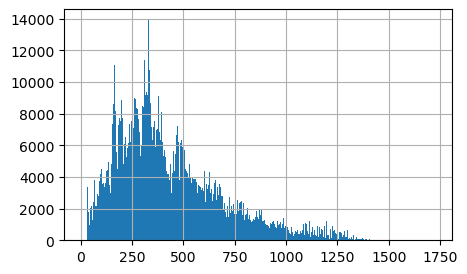

In [65]:
x_train['installment'].hist(figsize=(5, 3), bins=500);

## fico_range_high, fico_range_low

Диапазон верхней и нижней границы, к которому относится FICO заемщика при выдаче кредита.

In [66]:
print('Пропусков:', x_tmp[['fico_range_low', 'fico_range_high']].isna().sum().sum())

Пропусков: 0


Попробуем выделить дополнительный признак - среднее значение:

In [67]:
x_tmp = deepcopy(x_train)
x_tmp['fico_range_mean'] = (x_tmp['fico_range_high'] + x_tmp['fico_range_low']) / 2
# x_tmp = x_tmp.drop(['fico_range_high', 'fico_range_low'], axis=1)

In [68]:
check(x_tmp)

LGBMClassifier: 0.44647987633900926 

LogisticRegression: 0.40991182998024095


Метрика на тесте **не изменилась**.

## zip_code

В этом признаке находятся первые 3 цифры почтового индекса, указанные заемщиком в заявке на получение кредита.

In [69]:
x_train['zip_code'].value_counts().head()

945xx    12979
750xx    12823
112xx    12605
606xx    11289
300xx    11150
Name: zip_code, dtype: int64

 Попробуем выделить их в числовой признак:

In [70]:
x_tmp = deepcopy(x_train)
x_tmp = x_tmp.dropna(subset='zip_code')
x_tmp['zip_code'] = x_tmp['zip_code'].apply(lambda x: int(x[:3]))

In [71]:
check(x_tmp)

LGBMClassifier: 0.4468240043309241 

LogisticRegression: 0.40991888908875274


Метрика на **тесте снизилась**.

## int_rate

Процентная ставка по кредиту.

In [72]:
x_train['int_rate'].value_counts().head()

 10.99%    28586
 11.99%    27545
  5.32%    27417
 13.99%    25416
 11.49%    19940
Name: int_rate, dtype: int64

 Попробуем выделить числовой признак:

In [73]:
x_tmp = deepcopy(x_train)
x_tmp['int_rate'] = x_tmp['int_rate'].apply(lambda x: float(x[:-1]))

In [74]:
check(x_tmp)

LGBMClassifier: 0.4465380991659494 

LogisticRegression: 0.4093858371467888


Метрика на **тесте снизилась**.

# 4 Рекурсивное удаление признаков (кросс-валидация)

Сделаем копию фичей для дальнейшего рекурсивного удаления:

In [75]:
x_recursion = deepcopy(x_train)

## 4.1 Подготовка данных

### 4.1.1 Пропуски

Пропуски как и в прошлый раз заполним средним значением в цифровых и смежным в объектовых:

In [76]:
# числовые столбцы (среднее)
digit_df = x_recursion.select_dtypes(exclude=['object'])
for i in digit_df.columns[digit_df.isna().any()]:
    fill_value = x_recursion[i].mean()
    x_recursion[i] = x_recursion[i].fillna(fill_value)
    
# объектовые столбцы (мода)
obj_col = x_recursion.select_dtypes(include=['object']).columns
x_recursion[obj_col] = x_recursion[obj_col].apply(lambda x:x.fillna(x.value_counts().index[0]))

print('Пропусков:', x_recursion.isna().sum().sum())

Пропусков: 0


### 4.1.2 Кодирование

Закодируем не численные признаки:

In [77]:
obj_col = x_recursion.select_dtypes(include=['object']).columns
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(x_recursion[obj_col])
x_recursion[obj_col] = encoder.transform(x_recursion[obj_col])

## 4.2 Важность характеристик

Найдем feature_importances на примере LGBM модели для дальнейшего анализа:

In [78]:
params_lgbm = { 
    'max_depth': 9,                    
    'n_estimators': 96,       # 96                 
    'learning_rate': 0.27,   
    'boosting_type': 'gbdt',        
    'random_state': [RS]
}

In [79]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    clf = LGBMClassifier(**params_lgbm, verbose=-1).fit(x_recursion, y_train)

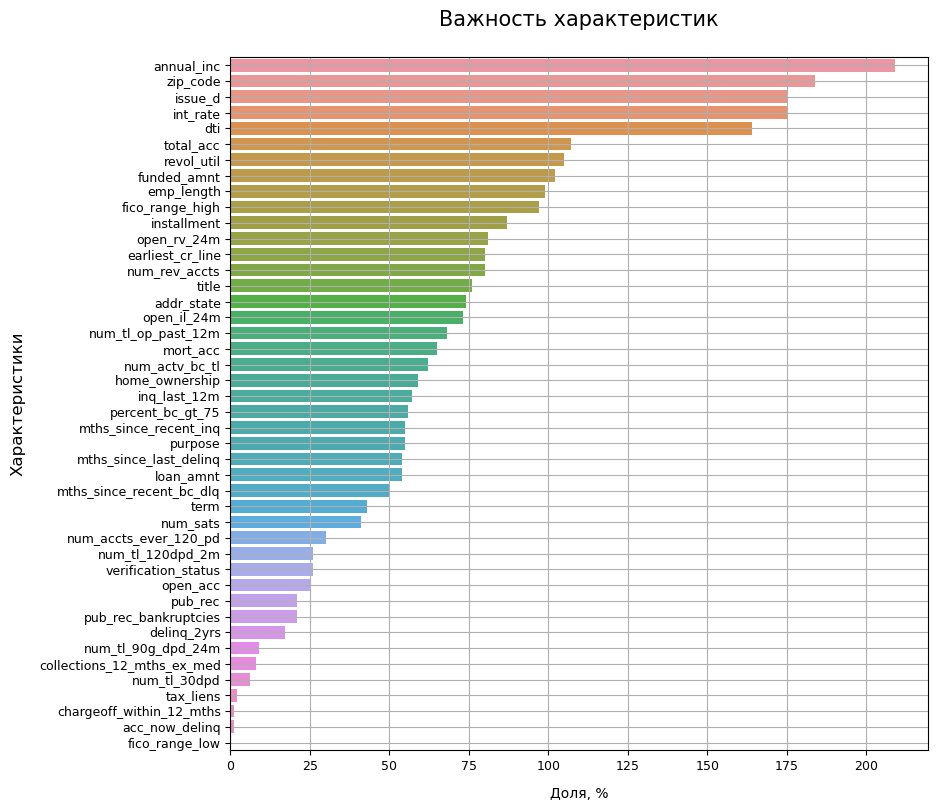

In [80]:
feat_imp_lgbm = pd.Series(clf.feature_importances_, x_recursion.columns)
feat_imp_lgbm.sort_values(inplace=True, ascending=False)

plt.figure(figsize=(9, 9))
sns.barplot(x=feat_imp_lgbm.values,
            y=feat_imp_lgbm.index,            
            orient='h');
plt.title('Важность характеристик\n', fontsize=15)
plt.xlabel('Доля, %', fontsize=10, labelpad=10)
plt.ylabel('Характеристики', fontsize=12, labelpad=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid('on')
plt.show()

## 4.3 Перебор фичей

In [81]:
# список признаков, удаление которых УЛУЧШАЕТ метрику
feat_del_lst = ['earliest_cr_line']

In [82]:
# список признаков, удаление которых СНИЖАЕТ метрику
feat_exception_lst = ['term', 'home_ownership', 'emp_length', 'annual_inc', 'int_rate']

In [83]:
# итоговый список признаков для перебора
feat_col = list(set(x_recursion.columns) - set(feat_del_lst) - set(feat_exception_lst))

In [84]:
'''Здесь осуществлялся рекурсивный перебор по признакам'''

x_tmp = deepcopy(x_recursion)
x_tmp = x_tmp.drop(labels=feat_del_lst, axis=1)
sc_lgbm, sc_lr = check(x_tmp, ret=True)

feat_tbl = pd.DataFrame({
    '-Признак': 'FULL', 
    'LGBM Gini': sc_lgbm,
    'LR Gini': sc_lr 
    }, index=[0])


for i in tqdm(feat_col):
    x_tmp = deepcopy(x_recursion)
    x_tmp = x_tmp.drop(labels=i, axis=1)
    x_tmp = x_tmp.drop(labels=feat_del_lst, axis=1) 
    feat_tbl.loc[-1] = [i, *check(x_tmp, out=False, ret=True)]   
    feat_tbl = feat_tbl.reset_index(drop=True)

LGBMClassifier: 0.4471769322378405 

LogisticRegression: 0.4099173449548493


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [33:36<00:00, 53.06s/it]


In [85]:
feat_tbl.sort_values(by=['LGBM Gini', 'LR Gini'], ascending=False)

,-Признак,LGBM Gini,LR Gini
19,mths_since_recent_bc_dlq,0.447393,0.409920
34,acc_now_delinq,0.447290,0.409912
14,loan_amnt,0.447236,0.409920
0,FULL,0.447177,0.409917
3,fico_range_high,0.447177,0.409916
28,fico_range_low,0.447177,0.409916
6,chargeoff_within_12_mths,0.447164,0.409921
10,inq_last_12m,0.447087,0.409876
25,collections_12_mths_ex_med,0.447067,0.409767
12,num_accts_ever_120_pd,0.447053,0.409895


При удалении `earliest_cr_line` **метрика на тесте становится хуже**

# 5 Корреляция

interval columns not set, guessing: ['acc_now_delinq', 'addr_state', 'annual_inc', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'dti', 'earliest_cr_line', 'emp_length', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'home_ownership', 'inq_last_12m', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'mort_acc', 'mths_since_last_delinq', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_rev_accts', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'open_il_24m', 'open_rv_24m', 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_util', 'tax_liens', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']


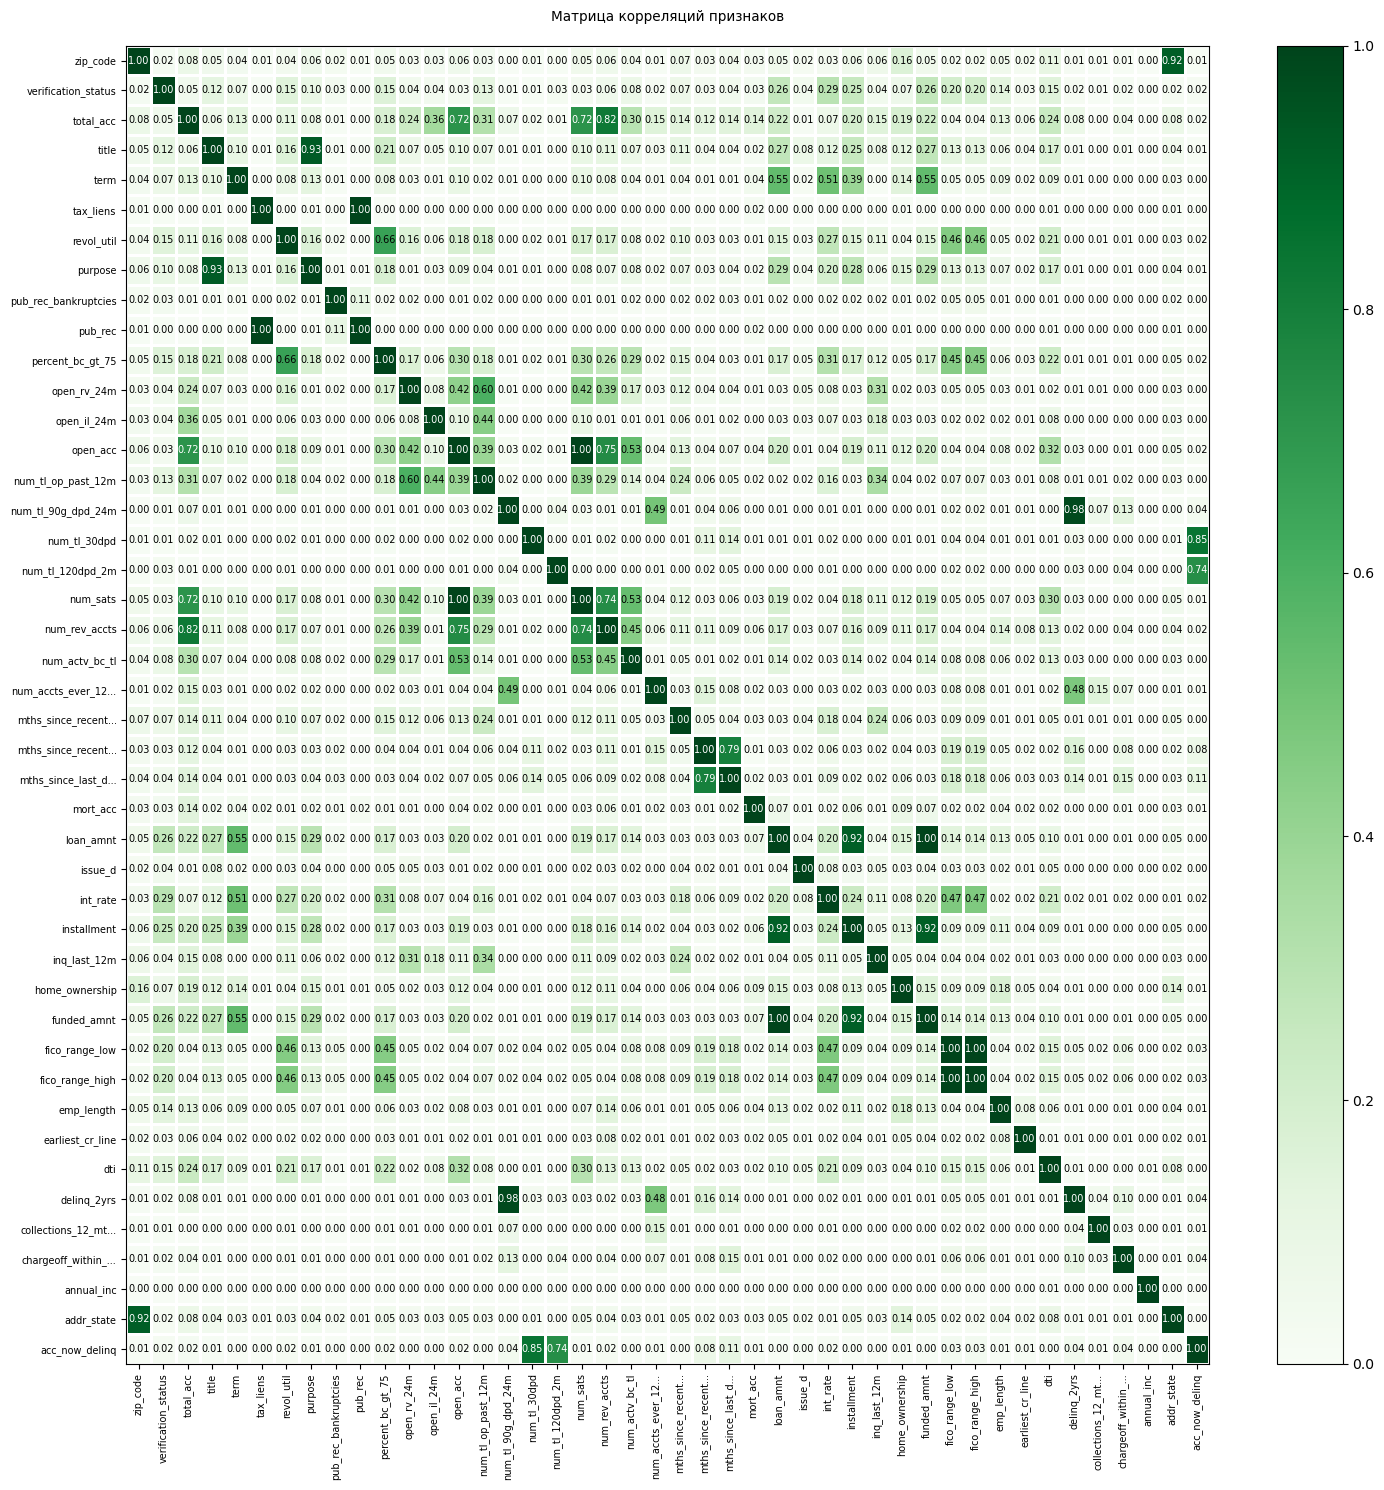

In [86]:
phik_overview = x_recursion.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title='Матрица корреляций признаков\n', 
                        fontsize_factor=0.7, 
                        figsize=(15, 15))

Список коррелирующих фичей:

pub_rec - tax_liens = 1.0  
num_sats - open_acc = 1.0  
funded_amnt - loan_amnt = 1.0  
fico_range_high - fico_range_low = 1.0  
delinq_2yrs - num_tl_90g_dpd_24m = 0.98  
purpose - title = 0.93  
zip_code - addr_state = 0.92    
installment - funded_amnt = 0.92  
installment - loan_amt = 0.92  

Кол-во пропусковпо столбцам для наглядности:

In [87]:
x_train.isna().sum().sort_values(ascending=False).head(24)

mths_since_recent_bc_dlq      917196
mths_since_last_delinq        607443
inq_last_12m                  567215
open_il_24m                   567214
open_rv_24m                   567214
mths_since_recent_inq         149781
num_tl_120dpd_2m               90608
emp_length                     71747
num_rev_accts                  45010
num_actv_bc_tl                 45009
num_tl_op_past_12m             45009
num_tl_90g_dpd_24m             45009
num_tl_30dpd                   45009
num_accts_ever_120_pd          45009
percent_bc_gt_75               44334
num_sats                       37295
mort_acc                       31541
title                          13800
revol_util                       841
pub_rec_bankruptcies             467
collections_12_mths_ex_med        37
chargeoff_within_12_mths          37
tax_liens                         28
zip_code                           1
dtype: int64

Попробуем удалить фичи с коэф. корреляции = 1:

In [88]:
corr_del_lst = ['tax_liens', 'num_sats', 'loan_amnt', 'num_tl_90g_dpd_24m']

Метрика на тесте **УЛУЧШИЛАСЬ** после удаления 4 признаков.

Внесем изменения в основной датасет:

In [89]:
x_train = x_train.drop(corr_del_lst, axis=1)

In [90]:
check(x_train)

LGBMClassifier: 0.4468357670949345 

LogisticRegression: 0.4098673308199626


# 6 Аномалии

Создадим копию фичей для работы с аномалиями:

In [17]:
x_knn = deepcopy(x_train) 

## 6.1 Предобработка

### 6.1.1 Выделение выборок

Для работы с аномалиями выделим валидационную выборку для тестирования:

In [52]:
(x_train_knn, x_valid_knn, 
 y_train_knn, y_valid_knn) = ( train_test_split(x_train, 
                                                y_train, 
                                                test_size=0.3,
                                                shuffle=True,
                                                random_state=RS) 
                     ) 

# check
# print('Размер обучающих выборок: ', x_train_knn.shape, y_train_knn.shape)
# print('Размер валидационных выборок: ', x_valid_knn.shape, y_valid_knn.shape)

### 6.1.2 Предобработка train

In [53]:
'''Обработка пропусков'''
# численные (среднее)
digit = x_train_knn.select_dtypes(exclude=['object'])
for i in digit.columns[digit.isna().any()]:
    fill_value = x_train_knn[i].mean()
    x_train_knn[i] = x_train_knn[i].fillna(fill_value)
# объектовые (мода)
obj = x_train_knn.select_dtypes(include=['object']).columns
x_train_knn[obj] = x_train_knn[obj].apply(lambda z:z.fillna(z.value_counts().index[0]))


'''Категорирование объектовых признаков'''
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(x_train_knn[obj])
x_train_knn[obj] = encoder.transform(x_train_knn[obj])

### 6.1.2 Предобработка valid

In [54]:
'''Обработка пропусков'''
# численные (среднее)
digit = x_valid_knn.select_dtypes(exclude=['object'])
for i in digit.columns[digit.isna().any()]:
    fill_value = x_valid_knn[i].mean()
    x_valid_knn[i] = x_valid_knn[i].fillna(fill_value)
# объектовые (мода)
obj = x_valid_knn.select_dtypes(include=['object']).columns
x_valid_knn[obj] = x_valid_knn[obj].apply(lambda z:z.fillna(z.value_counts().index[0]))


'''Категорирование объектовых признаков'''
x_valid_knn[obj] = encoder.transform(x_valid_knn[obj])

## 6.2 Поиск

In [ ]:
def knn_del(contamination, n_neighbors, out=False, ret=True, cv=CV):
    
    x_t = deepcopy(x_train_knn)
    y_t = deepcopy(y_train_knn)
    x_v = deepcopy(x_valid_knn)
    y_v = deepcopy(y_valid_knn)
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        '''KNN'''
        knn = KNN(contamination=contamination, n_neighbors=n_neighbors)
        knn.fit(x_t)
        knn_lst = knn.predict(x_t)
        x_t = x_t[knn_lst != 1]
        y_t = y_t[knn_lst != 1]

        # valid
        knn_lst_valid = knn.predict(x_v)
        x_v = x_v[knn_lst_valid != 1]
        y_v = y_v[knn_lst_valid != 1]

        # обучение, метрика
        clf = LGBMClassifier(**params_lgbm, verbose=-1).fit(x_t, y_t)
        predictions = clf.predict_proba(x_v)[:, 1]
        score = gini_score(y_v, predictions)
        
    if out == True:
        print('\n\nLGBMClassifier:', lgbm_sc)

    if ret == True:
        return lgbm_sc

In [63]:
'''Здесь осуществлялся перебор в циклах'''

knn_tbl = pd.DataFrame(columns=['c', 'n', 'LGBM Gini'])

for c in tqdm(np.arange(0.01, 0.1, 0.02)):
    for n in range(2, 3):
        knn_tbl.loc[-1] = [c, n, knn_del(c, n)]   
        knn_tbl = knn_tbl.reset_index(drop=True)       

In [40]:
knn_tbl.sort_values(by='LGBM Gini', ascending=False) 

,c,n,LGBM Gini
1,0.03,2.0,0.359217
0,0.01,2.0,0.356439
4,0.09,2.0,0.351716
3,0.07,2.0,0.349816
2,0.05,2.0,0.344164


По итогам поиска и удаления аномалий, метрика на **тесте снизилась**

# 7 Обучение итоговых моделей

## 7.1 Предобработка

### 7.1.1 Пропуски

In [103]:
# численные (среднее)
digit = x_train.select_dtypes(exclude=['object'])
for i in digit.columns[digit.isna().any()]:
    fill_value = x_train[i].mean()
    x_train[i] = x_train[i].fillna(fill_value)
    
# объектовые (мода)
obj = x_train.select_dtypes(include=['object']).columns
x_train[obj] = x_train[obj].apply(lambda z:z.fillna(z.value_counts().index[0]))

### 7.1.2 Кодирование

In [104]:
'''Ordinal Encoder'''

ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
ord_encoder.fit(x_train[obj])
x_train[obj] = ord_encoder.transform(x_train[obj])

In [20]:
# '''One Hot Encoder'''

# ohe_encoder = OneHotEncoder(handle_unknown='ignore')
# ohe_encoder.fit(x_train)
# x_train = ohe_encoder.transform(x_train)

### 7.1.2 Масштабирование

In [105]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_sc = deepcopy(x_train)
x_train_sc = scaler.transform(x_train_sc)

## 7.2 Подбор гиперпараметров

**Функция**

In [106]:
def model_create(model, params, x, scoring=gini, cv=CV, out=True):
    '''Создает и обучает модель перебором параметров. 
        Выводит лучшую метрику и параметры'''
    
    mdl = GridSearchCV(model, params, cv=cv, scoring=scoring, n_jobs=-1)
    mdl.fit(x, y_train)
    score = abs(mdl.best_score_).round(7)
    
    if out==True:
        print(
            f'Gini модели {model.__class__.__name__} = {score}',
            f'Лучшие гиперпараметры:',
            sep='\n\n'
        )
        display(mdl.best_params_)
        
    return mdl.best_estimator_, score

### LogisticRegression

In [107]:
%%time

params_lr = { 
    'penalty': ['l2'],                         # l2    # 'l1', 'l2', 'elasticnet', None}
    'C': np.arange(0.75, 0.76, 0.01),          # 0.75
    'class_weight': [None],                    # None
    'random_state': [RS],                      
    'solver': ['lbfgs']                        # lbfgs ('lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga')
         }

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    mdl_lr, lr_score = model_create(LogisticRegression(), params_lr, x=x_train_sc)   # 0.4098673 / 33.6

Gini модели LogisticRegression = 0.4098673

Лучшие гиперпараметры:


{'C': 0.76,
 'class_weight': None,
 'penalty': 'l2',
 'random_state': 321,
 'solver': 'lbfgs'}

CPU times: total: 20.4 s
Wall time: 33.6 s


### LightGBM

In [109]:
%%time

params_lgbm = { 
    'max_depth': range(4, 5, 1),                            # 4,   6, 8, 14, 18   (1-30)  
    'n_estimators': range(240, 241, 1),                     # 240   (1-1000)       
    'learning_rate': np.arange(0.27, 0.28, 0.01),           # 0.27  0.29 (0.1-0.9)
    'subsample_for_bin': range(230_000, 231_000, 2_000),    # 230_000
    'num_leaves': range(31, 32, 1),                         # 31
    'boosting_type': ['gbdt'],                              # gbdt  ('gbdt', 'dart', 'goss')  dart в 4 раза дольше
    'random_state': [RS]
}    
    
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    mdl_lgbm, lgbm_score = model_create(LGBMClassifier(verbose=-1), params_lgbm, x=x_train)   # 0.4504922 / 115

Gini модели LGBMClassifier = 0.4504922

Лучшие гиперпараметры:


{'boosting_type': 'gbdt',
 'learning_rate': 0.28,
 'max_depth': 4,
 'n_estimators': 240,
 'num_leaves': 31,
 'random_state': 321,
 'subsample_for_bin': 230000}

CPU times: total: 54 s
Wall time: 1min 55s


### Catboost

In [110]:
%%time

params_cat = { 
    'max_depth':  range(8, 9, 1),                      # 8         
    'n_estimators': range(322, 323, 2),                # 322          
    'learning_rate': np.arange(0.20, 0.21, 0.01),      # 0.20                 
    'silent': [True],   
    'random_seed': [RS],
}

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    mdl_cat, cat_score = model_create(CatBoostClassifier(), params_cat, x=x_train)   # 0.4508774 / 199c

Gini модели CatBoostClassifier = 0.4508774

Лучшие гиперпараметры:


{'learning_rate': 0.2,
 'max_depth': 8,
 'n_estimators': 322,
 'random_seed': 321,
 'silent': True}

CPU times: total: 5min 19s
Wall time: 5min 34s


### XGBoost

In [112]:
%%time

params_xgb = { 
    'max_depth': range(8, 9, 1),                            # 
    'n_estimators': range(322, 323, 1),                     #       
    'learning_rate': np.arange(0.20, 0.21, 0.01),           #
    'random_state': [RS]
}

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    mdl_lgbm, lgbm_score = model_create(XGBClassifier(), params_xgb, x=x_train)   # 0.4502168   / 114

Gini модели XGBClassifier = 0.44135

Лучшие гиперпараметры:


{'learning_rate': 0.2,
 'max_depth': 8,
 'n_estimators': 322,
 'random_state': 321}

CPU times: total: 51min 11s
Wall time: 1h 15min 35s


In [ ]:
# lgbm param 0.4500501
# cat  param 0.4413500

# 8 Тестирование

## 8.1 Предобработка тестовой выборки

**Предобработка признаков**

In [113]:
'''Словарь'''
x_test['emp_length'] = x_test['emp_length'].replace(replace_dict)

'''Удаление колонок'''
x_test = x_test.loc[:, x_train.columns]

**Пропуски**

In [114]:
# численные
digit_test = x_test.select_dtypes(exclude=['object'])
for i in digit_test.columns[digit_test.isna().any()]:
    fill_value = x_test[i].mean()
    x_test[i] = x_test[i].fillna(fill_value)
# объектовые
x_test[obj] = x_test[obj].apply(lambda x:x.fillna(x.value_counts().index[0]))

**Кодирование**

In [115]:
x_test[obj] = ord_encoder.transform(x_test[obj])

## 8.2 Предсказания

Нужную модель расскоментировать и закоментировать остальные!

### Catboost

In [117]:
params_cat_test = { 
    'max_depth': 8,                    
    'n_estimators': 322,                      
    'learning_rate': 0.2,  
    'silent': True,
    'random_state': RS
}



mdl_cat_test = CatBoostClassifier(**params_cat_test)
mdl_cat_test.fit(x_train, y_train)
predictions_cat = mdl_cat_test.predict_proba(x_test)

pd.DataFrame(predictions_cat[:, 1], index=x_test.index, columns=['loan_status']).to_csv('answer.csv')

In [118]:
data_load('answer.csv').sort_index().tail(3)

answer.csv успешно загружен!


,loan_status
index,
590974,0.231047
590975,0.059056
590976,0.226439


### LightGBM

In [ ]:
# params_lgbm = { 
#     'max_depth': 4,                    
#     'n_estimators': 240,                      
#     'learning_rate': 0.27,         
#     'subsample_for_bin': 230_000,  
#     'num_leaves': 31,                          
#     'boosting_type': 'gbdt', 
#     'random_state': RS
# }

In [ ]:
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     mdl_lgbm = LGBMClassifier(**params_lgbm, verbose=-1)
#     mdl_lgbm.fit(x_train, y_train)
#     predictions_lgbm = mdl_lgbm.predict_proba(x_test)

# pd.DataFrame(predictions_lgbm[:, 1], index=x_test.index, columns=['loan_status']).to_csv('answer.csv')

In [ ]:
# data_load('answer.csv').sort_index().tail(3)

### XGBoost

In [ ]:
# params_xgb = { 
#     'max_depth': 4,                    
#     'n_estimators': 240,                      
#     'learning_rate': 0.27,                                    
#     'boosting_type': 'gbdt', 
#     'random_state': RS
# }


# mdl_xgb_test = XGBClassifier(**params_xgb, verbose=-1)
# mdl_xgb_test.fit(x_train, y_train)
# predictions_xgb = mdl_xgb_test.predict_proba(x_test)

# pd.DataFrame(predictions_xgb[:, 1], index=x_test.index, columns=['loan_status']).to_csv('answer.csv')

In [ ]:
# data_load('answer.csv').sort_index().tail(3)

## LogisticRegression

### Масштабирование

In [120]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_sc = deepcopy(x_train)
x_train_sc = scaler.transform(x_train_sc)

x_test_sc = deepcopy(x_test)
x_test_sc = scaler.transform(x_test_sc)

In [ ]:
# mdl_lr_test = LogisticRegression(**params_lr)
# mdl_lr_test.fit(x_train_sc, y_train.loc[x_train_test.index])
# predictions_lr = mdl_lr_test.predict_proba(x_test_sc)

# pd.DataFrame(predictions_lr[:, 1], index=x_test.index, columns=['loan_status']).to_csv('answer.csv')

In [ ]:
# data_load('answer.csv').sort_index().tail(3)